# Advanced Lane Finding

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
- Video pipeline

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

## 1. Comupute the Camera Calibration Matrix and Distortion Coefficients Given a Set of Chessboard Images

In [2]:
# Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images
objpoints = []
imgpoints = []

# Prepare object points
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

for fname in images:
    # Read in each image
    img = cv2.imread(fname)

    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

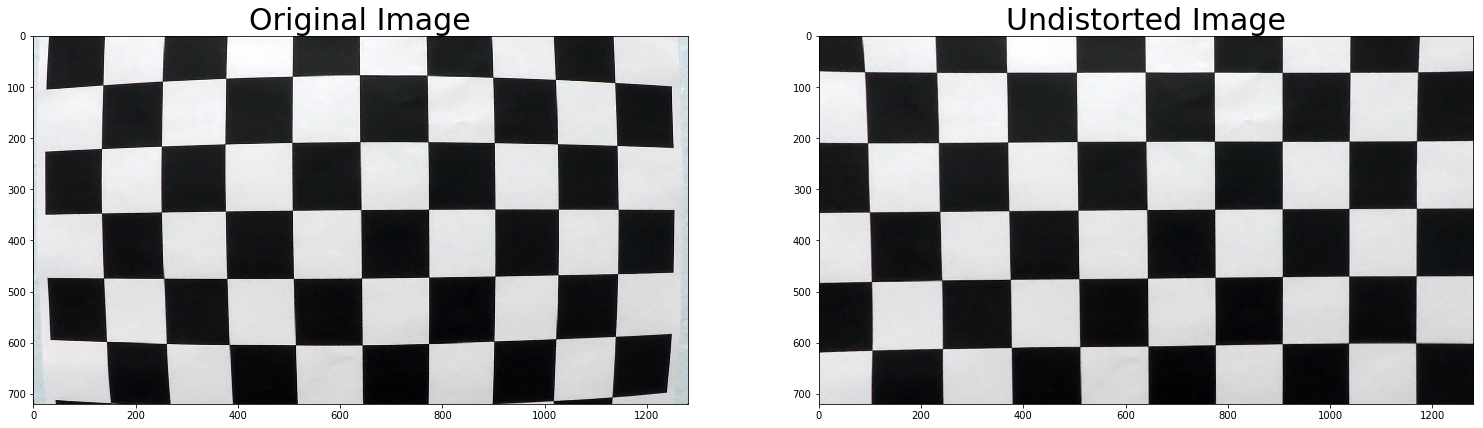

In [3]:
# Test undistortion on an images
test_img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (test_img.shape[1], test_img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                   img_size, None, None)
dst = cv2.undistort(test_img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/calibration1_undist.jpg', dst)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle ["mtx"] = mtx
dist_pickle ["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/calibration.p", "wb"))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/test_undistort.png')

## 2. Apply a Distortion Correction to Raw Images

True

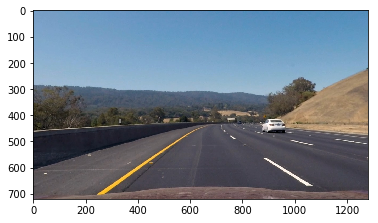

In [4]:
# Load camera calibration
dist_pickle = pickle.load(open("camera_cal/calibration.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

img = mpimg.imread('test_images/test3.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)

plt.imshow(undist)

r,g,b = cv2.split(undist)
undist = cv2.merge((b,g,r))

cv2.imwrite('output_images/output_test.jpg', undist)

## 3. Use Color Transforms, Gradients, etc., to Create a Thresholded Binary Image

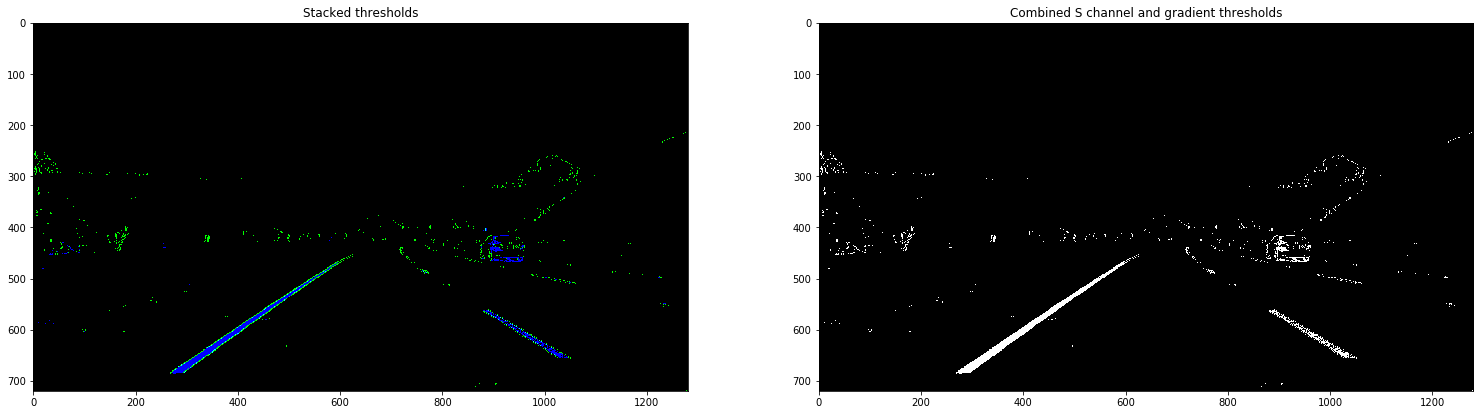

In [5]:
def threshold(img, sx_thresh, s_thresh):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary ==1)] = 1
    
    return color_binary, combined_binary
    
color_binary, combined_binary = threshold(img, sx_thresh=(50,100), s_thresh=(170, 255))

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/combined_binary.jpg')

## 4. Apply a Perspective Transform to Rectify Binary Image ("Birds-Eye View")

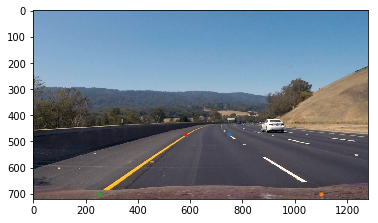

In [6]:
# Four square coordinates

plt.imshow(img)
plt.plot(750, 470, '.') # top right
plt.plot(1100, 700, '.') # bottom right
plt.plot(250, 700, '.') # bottom left
plt.plot(580, 470, '.') # top left

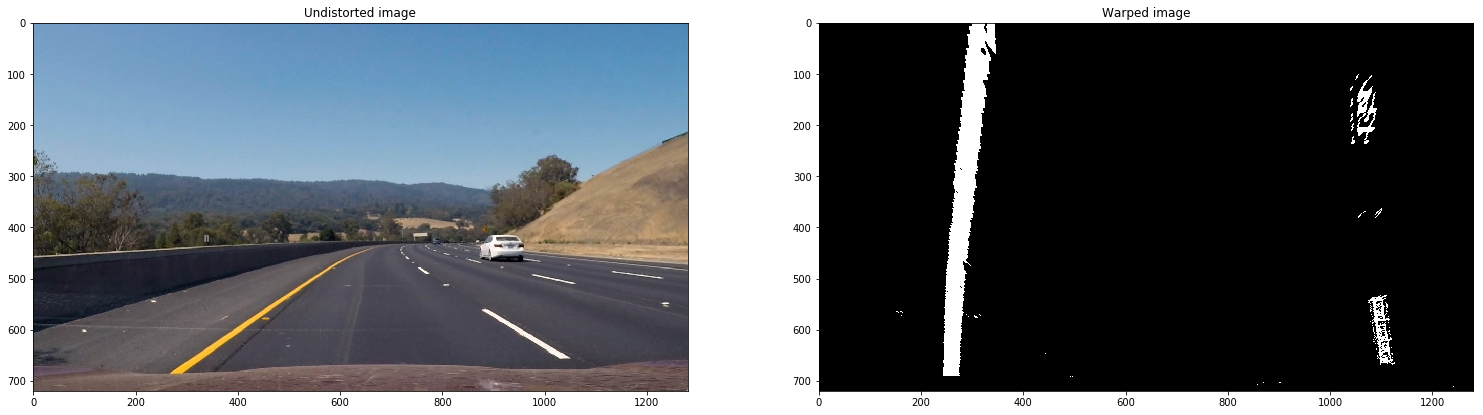

In [7]:
def warp(img):
    
    img_size = (img.shape[1], img.shape[0])
    
    # Four square coordinates
    src = np.float32(
        [[750, 470],
         [1100, 700],
         [250, 700],
         [580, 470]])
    
    # Four desired coordinates
    dst = np.float32(
        [[1100, 0],
         [1100, 700],
         [250, 700],
         [250, 0]])
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse perspective transform, Minv
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image
    warped_image = cv2.warpPerspective(img, M, img_size)
    
    return warped_image, Minv

# Get perspective transform
warped_image, Minv = warp(combined_binary)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('Undistorted image')
ax1.imshow(img)

ax2.set_title('Warped image')
ax2.imshow(warped_image, cmap='gray')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/warped_lines.jpg')

## 5. Detect Lane Pixels and Fit to Find the Lane Boundary

### Implement Sliding Windows and Fit a Polynomial

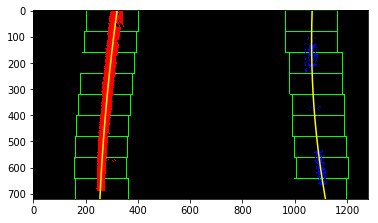

In [8]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Visualization
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

out_img, left_fit, right_fit = fit_polynomial(warped_image)
plt.imshow(out_img)

### Fit a Polynomial Using Previous Polynomial

True

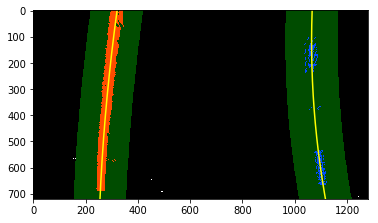

In [9]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(warped_image.shape, leftx, lefty, rightx, righty)
    
    # Visualization
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return result, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds

result, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds = search_around_poly(warped_image)
plt.imshow(result)
cv2.imwrite('output_images/fit_lines.jpg', result)

## 6. Determine the Curvature of The Lane and Vehicle Position with Respect to Center

### Curvature of The Lane

In [10]:
def calc_curv(binary_image, left_fit, right_fit, left_lane_inds, right_lane_inds):
    
    img_size = (binary_image.shape[1], binary_image.shape[0])

    ploty = np.linspace(0, img_size[1]-1, img_size[1]) # to cover same y-range as image
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Grab activated pixels
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
     
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate average curvature
    avg_curverad = (left_curverad + right_curverad)/2
    
    return avg_curverad

avg_curverad = calc_curv(warped_image, left_fit, right_fit, left_lane_inds, right_lane_inds)
print(avg_curverad, 'm')

1831.32919073 m


### Vehicle Position with Respect to Center

In [11]:
def v_position(img, left_fitx, right_fitx):
    
    #The camera is in the middle of the image and is also the center of the car
    
    # Calculate x coordinate of the midpoint of the left and right lane lines
    lane_center = (left_fitx[-1] + right_fitx[-1])/2
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Calculate the distance between the camera and the center of the lane line
    center_offset_pixels = img_size[0]/2 - lane_center
    center_offset_mtrs = xm_per_pix*center_offset_pixels

    return center_offset_mtrs
    
offset = v_position(img, left_fitx, right_fitx)
print(offset)

-0.244540645529


## 7. Warp The Detected Lane Boundaries Back onto The Original Image

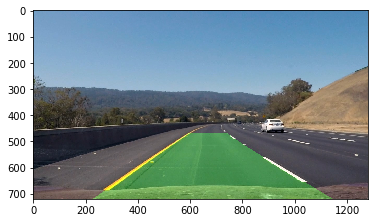

In [12]:
def drawing(undist, bin_warped, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

result_weighted = drawing(img, warped_image, left_fitx, right_fitx)
plt.imshow(result_weighted)

## 8. Output Visual Display of The Lane Boundaries and Numerical Estimation of Lane Curvature and Vehicle Position

True

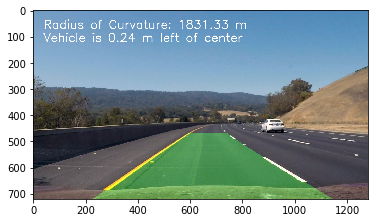

In [13]:
def overlay(image, avg_curverad, offset):
    
    new_img = np.copy(image)
    
    # Define font and color
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_color = (255,255,255)
    
    # Define text
    text = 'Radius of Curvature: ' + '{:.2f}'.format(avg_curverad) + ' m'
    cv2.putText(new_img, text, (40,70), font, 1.5, font_color, 2, cv2.LINE_AA)
    
    if offset > 0:
        direction = 'right'
    else:
        direction = 'left'
    
    abs_dist = abs(offset)
    
    text = 'Vehicle is ' + '{:.2f}'.format(abs_dist) + ' m ' + direction + ' of center'
    
    cv2.putText(new_img, text, (40,120), font, 1.5, font_color, 2, cv2.LINE_AA)
    
    return new_img

final = overlay(result_weighted, avg_curverad, offset)
plt.imshow(final)

r,g,b = cv2.split(final)
final = cv2.merge((b,g,r))

cv2.imwrite('output_images/output.jpg', final)

## Image Pipeline

In [14]:
def pipeline(image):
    
    # 1. Distortion Correction
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    # 2. Thresholded Binary Image
    color_binary, combined_binary = threshold(image_undistorted, sx_thresh=(50,100), s_thresh=(170,255))
    
    # 3. Perspective Transform
    warped_image, Minv = warp(combined_binary)
    
    # 4. Fit a Polynomial
    out_img, left_fit, right_fit = fit_polynomial(warped_image)
    result, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds = search_around_poly(warped_image)
    
    # 5. Curvature of The Land and Vehicle Position with Respect to Center
    avg_curverad = calc_curv(warped_image, left_fit, right_fit, left_lane_inds, right_lane_inds)
    offset = v_position(image, left_fitx, right_fitx)
    
    # 6. Warp the Detected lane Boundaries Back onto The Original Image
    result_weighted = drawing(image, warped_image, left_fitx, right_fitx)

    # 7. Visual Display
    final = overlay(result_weighted, avg_curverad, offset)
    
    return final

## Video Pipeline

In [15]:
# Import everthing nedded to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:18<00:00,  3.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 53s, sys: 16.9 s, total: 3min 10s
Wall time: 5min 21s


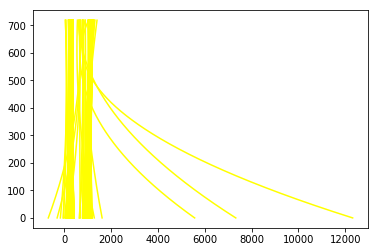

In [16]:
def process_image(image):
    result = pipeline(image)
    return result

white_output = 'project_video_output.mp4'

clip1 = VideoFileClip("project_video.mp4")
    
white_clip = clip1.fl_image(process_image)

%time white_clip.write_videofile(white_output, audio=False)